# Aspect Based Sentiment Analysis Using Machine Learning

By: Umair Cheema & Athar Pasha

**Objective:**

The objective of our project is to employ Machine Learning algorithms for _Aspect Based Sentiment Analysis_. Sentiment Analysis is defined as the field of study that analyses people’s opinions, sentiment appraisals, attitudes, and emotions towards entities and their attributes expressed in written text[1]. Aspect Based sentiment analysis goes one step further and tries to find opinions about a particular attribute of an opinion target. As an example in the sentence, _'iPhone 7 is super fast and has stunning display, I just wish that the battery could last even longer'_ the sentiment regarding the the display is quite positive whereas the sentiment on battery is mildly negative. A document, paragraph or sentence level sentiment analysis approaches will not be able to distinguish between the difference in sentiment about different aspects of iPhone. _Please note that the review quoted above is fictitious, iPhone is an awesome device!_. 


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import re


### 1) Data Preparation 

The datasets used for this project are made available by International Workshop on Semantic Evaluation 2016 <a href = 'http://alt.qcri.org/semeval2016/' target='_blank'>SemEval2016</a> and Yelp dataset challenge <a href='https://www.yelp.com.au/dataset_challenge' target='_blank'>Yelp dataset challenge</a>. The use of these datasets is protected by their respective license terms and any data or subsets submitted as part of this project are only for Machine Learning and Data Mining Course staff for evaluation purposes and is not meant be distributed or shared.

The most challenging aspect of Semantic Evaluation dataset is that the dataset has only 325 examples with labeled Aspects and Sentiments.

In [2]:
# Read the Semeval data and return a dataframe for multi-label multi-output classification
def read_semeval_data(filename):
    '''
    Description: reads Semantic Evaluation XML dataset and converts into a 
                 dataframe
    Arguments:
                 filename: string with file path (including filename)
    Returns :    pandas data frame
    Important:   this function only puts positive and neutral reviews in dataframe                          
    '''
    f = open(filename, 'r')
    raw_training_data = f.read()
    xmldoc = BeautifulSoup(raw_training_data,'lxml-xml')
    sentences = xmldoc.Reviews.find_all('sentences')
    opinions = xmldoc.Reviews.find_all('Opinions')
    reviews = []
    for i in range(0,len(sentences)):
        record = {}
        entity_aspect_pairs = opinions[i].find_all('Opinion')
        for ea_pair in entity_aspect_pairs:
            ea = ea_pair.attrs['category']
            polarity = ea_pair.attrs['polarity']
            if(polarity == 'positive'):
                record[ea] = 1
            elif(polarity == 'negative'):
                record[ea] = -1
            else:
                record[ea] = 0           
        record['TEXT'] = sentences[i].get_text()
        reviews.append(record)
    #Create a dataframe
    df=pd.DataFrame(reviews)
    #Change order of the columns so that text appears first
    cols = df.columns.tolist()
    cols.sort()
    cols.reverse()
    df = df[cols]
    df.fillna(0, inplace=True)
    return df

In [3]:
# Read the Semeval data and return a dataframe for multi-label only
def read_semeval_data_multilabel(filename):
    '''
    Description: reads Semantic Evaluation XML dataset and converts into a 
                 dataframe with Multilabel data
    Arguments:
                 filename: string with file path (including filename)
    Returns :    pandas data frame
    Important:   this function only puts positive and neutral reviews in dataframe                          
    '''
    possible_labels=['SERVICE#GENERAL#POSITIVE', 'SERVICE#GENERAL#NEGATIVE', 'RESTAURANT#PRICES#POSITIVE', 
                     'RESTAURANT#PRICES#NEGATIVE', 'RESTAURANT#MISCELLANEOUS#POSITIVE', 
                     'RESTAURANT#MISCELLANEOUS#NEGATIVE', 'RESTAURANT#GENERAL#POSITIVE', 'RESTAURANT#GENERAL#NEGATIVE',
                     'LOCATION#GENERAL#POSITIVE', 'LOCATION#GENERAL#NEGATIVE', 'FOOD#STYLE_OPTIONS#POSITIVE', 
                     'FOOD#STYLE_OPTIONS#NEGATIVE', 'FOOD#QUALITY#POSITIVE', 'FOOD#QUALITY#NEGATIVE', 
                     'FOOD#PRICES#POSITIVE', 'FOOD#PRICES#NEGATIVE', 'DRINKS#STYLE_OPTIONS#POSITIVE', 
                     'DRINKS#STYLE_OPTIONS#NEGATIVE', 'DRINKS#QUALITY#POSITIVE', 'DRINKS#QUALITY#NEGATIVE', 
                     'DRINKS#PRICES#POSITIVE', 'DRINKS#PRICES#NEGATIVE', 'AMBIENCE#GENERAL#POSITIVE', 
                     'AMBIENCE#GENERAL#NEGATIVE']
    f = open(filename, 'r')
    raw_training_data = f.read()
    xmldoc = BeautifulSoup(raw_training_data,'lxml-xml')
    sentences = xmldoc.Reviews.find_all('sentences')
    opinions = xmldoc.Reviews.find_all('Opinions')
    reviews = []
    for i in range(0,len(sentences)):
        record = {}
        entity_aspect_pairs = opinions[i].find_all('Opinion')
        for ea_pair in entity_aspect_pairs:
            ea = ea_pair.attrs['category']
            polarity = ea_pair.attrs['polarity']
            if(polarity == 'positive'):
                record[ea+'#POSITIVE'] = 1
            elif(polarity == 'negative'):
                record[ea+'#NEGATIVE'] = 1
            else:
                record[ea+'#POSITIVE'] = 0
                record[ea+'#NEGATIVE'] = 0
        record['TEXT'] = sentences[i].get_text()
        reviews.append(record)
    #Create a dataframe
    df=pd.DataFrame(reviews)
    #Change order of the columns so that text appears first
    cols = df.columns.tolist()
    for label in possible_labels:
        if(label not in cols):
            df[label] = 0
    cols = df.columns.tolist()
    cols.sort()
    cols.reverse()
    df = df[cols]
    df.fillna(0, inplace=True)
    return df

entity_labels = ['Food','Drinks','Service','Ambience','Location','Restaurant']
<br/>attributes_labels = ['General','Prices','Quality','Style&Options','Miscellaneous']

##### Possible Combinations of Entities and Attributes #####

<img src='images/entity_attributes_combinations.jpg' style='width:50;height:50'>

In [4]:
df_training = read_semeval_data('data/train.xml')
df_testing = read_semeval_data('data/test.xml')
df_testing.head()

,TEXT,SERVICE#GENERAL,RESTAURANT#PRICES,RESTAURANT#MISCELLANEOUS,RESTAURANT#GENERAL,LOCATION#GENERAL,FOOD#STYLE_OPTIONS,FOOD#QUALITY,FOOD#PRICES,DRINKS#STYLE_OPTIONS,DRINKS#QUALITY,DRINKS#PRICES,AMBIENCE#GENERAL
0,\n\nYum!\n\n\nServes really good sushi.\n\n\nN...,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,\n\nNo Comparison\n\n\n– I can't say enough ab...,1.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,\n\nSnotty Attitude\n\n\n– We were treated ver...,-1.0,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,\n\nGood food!\n\n\n– We love breakfast food.\...,1.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,\n\nOverrated\n\n\n– I was highly disappointed...,0.0,-1.0,0.0,-1,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0


In the dataframe above a +1 indicates a positive polarity and -1 indicates negative polarity whereas 0 means that this aspect is not found or found to be neutral

In [5]:
#Read multilabel data only
df_training_multilabel = read_semeval_data_multilabel('data/train.xml')
df_testing_multilabel = read_semeval_data_multilabel('data/test.xml')

In [6]:
df_testing_multilabel.head()

,TEXT,SERVICE#GENERAL#POSITIVE,SERVICE#GENERAL#NEGATIVE,RESTAURANT#PRICES#POSITIVE,RESTAURANT#PRICES#NEGATIVE,RESTAURANT#MISCELLANEOUS#POSITIVE,RESTAURANT#MISCELLANEOUS#NEGATIVE,RESTAURANT#GENERAL#POSITIVE,RESTAURANT#GENERAL#NEGATIVE,LOCATION#GENERAL#POSITIVE,...,FOOD#PRICES#POSITIVE,FOOD#PRICES#NEGATIVE,DRINKS#STYLE_OPTIONS#POSITIVE,DRINKS#STYLE_OPTIONS#NEGATIVE,DRINKS#QUALITY#POSITIVE,DRINKS#QUALITY#NEGATIVE,DRINKS#PRICES#POSITIVE,DRINKS#PRICES#NEGATIVE,AMBIENCE#GENERAL#POSITIVE,AMBIENCE#GENERAL#NEGATIVE
0,\n\nYum!\n\n\nServes really good sushi.\n\n\nN...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1,\n\nNo Comparison\n\n\n– I can't say enough ab...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
2,\n\nSnotty Attitude\n\n\n– We were treated ver...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
3,\n\nGood food!\n\n\n– We love breakfast food.\...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
4,\n\nOverrated\n\n\n– I was highly disappointed...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0


In [7]:
#Function to clean the text data
#Remove punctuations, newline characters and convert to lowercase.
#Note that we are not removing dot to mark sentence boundary
def clean_text_data(data, remove_stopwords = False):
    '''
    Description: Given text returns cleaned version
    Arguments:
                  data: string with raw review text
    Returns  :
                  cleaned: string with unwanted characters removed
    '''
    data = str(data).strip()
    stopwords_ = stopwords.words('english')
    prog = re.compile('[\t\n\r\f\v\d\']', re.UNICODE)
    data = re.sub(prog, ' ', data).lower()
    prog = re.compile('[!\"#$%&\'()*+–\,-/:;<=>?@[\]^_`{|}~]', re.UNICODE)
    cleaned = re.sub(prog, ' ', data)
    #Remove multiple whitespaces
    cleaned = re.sub(' +',' ',cleaned)
    if(remove_stopwords):
        words = word_tokenize(cleaned)
        sample = []
        for word in words:
            if word not in stopwords_:
                sample.append(word)
        cleaned = ' '.join([i for i in sample])
    return cleaned

Note that we are not removing the stopwords. One reason is that often builtin stopwords lists for English language contain the word 'no', 'nor','not' etc. If removed it can change the sentiment e.g 'Food is not good' and 'Food is good' both will become 'Food good'. It is therefore decided not to remove stopwords.

In [8]:
df_training['TEXT'] = df_training['TEXT'].apply(clean_text_data)
df_testing['TEXT'] = df_testing['TEXT'].apply(clean_text_data)
df_training_multilabel['TEXT'] = df_training_multilabel['TEXT'].apply(clean_text_data)
df_testing_multilabel['TEXT'] = df_testing_multilabel['TEXT'].apply(clean_text_data)

In [9]:
df_testing_multilabel.tail()

,TEXT,SERVICE#GENERAL#POSITIVE,SERVICE#GENERAL#NEGATIVE,RESTAURANT#PRICES#POSITIVE,RESTAURANT#PRICES#NEGATIVE,RESTAURANT#MISCELLANEOUS#POSITIVE,RESTAURANT#MISCELLANEOUS#NEGATIVE,RESTAURANT#GENERAL#POSITIVE,RESTAURANT#GENERAL#NEGATIVE,LOCATION#GENERAL#POSITIVE,...,FOOD#PRICES#POSITIVE,FOOD#PRICES#NEGATIVE,DRINKS#STYLE_OPTIONS#POSITIVE,DRINKS#STYLE_OPTIONS#NEGATIVE,DRINKS#QUALITY#POSITIVE,DRINKS#QUALITY#NEGATIVE,DRINKS#PRICES#POSITIVE,DRINKS#PRICES#NEGATIVE,AMBIENCE#GENERAL#POSITIVE,AMBIENCE#GENERAL#NEGATIVE
85,sit in the balcony not bad food was good and a...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0
86,late night dinning with exeptional food i didn...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0
87,this place rocks mercedes restaurant is so tas...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1.0,0.0
88,insultingly overpriced mediocre service qualit...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0,0,1.0,1.0,0.0
89,much more than just a great view i am exceedin...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


**Yelp data**

Yelp dataset is quite large and contains customer reviews for different kind of businesses. We however only needed reviews for Restaurants for generating domain specific WordEmbeddings. Fortunately we found yelp utils project on github.

<a href='https://github.com/titipata/yelp_dataset_challenge' target='_blank'>Yelp Dataset Challenge Utils Project</a>. 

The project however did not update to the latest version of Tensorflow for creating the Word Embeddings so we forked the repo, modified it and did a pull request that was merged to the master by the owner of the repo.

**_Important: The following sections require that you either generate the Yelp domain specific word embeddings and raw reviews text from Yelp dataset utils tools available at _** 

<a href = 'https://github.com/umairacheema/yelp_dataset_challenge' target='_blank '>Yelp dataset tools branch</a>

**OR**

Download them from 

<a href='https://drive.google.com/drive/folders/0By6XWYwKssBmRHRIVVp0UVlzdHM' target='_blank'> Yelp Restaurant Reviews Download </a>

and save them in the **data** folder.

### 2) Exploratory Data Analysis

Check the distribution of the words in the SemEval 2016 training and testing reviews.

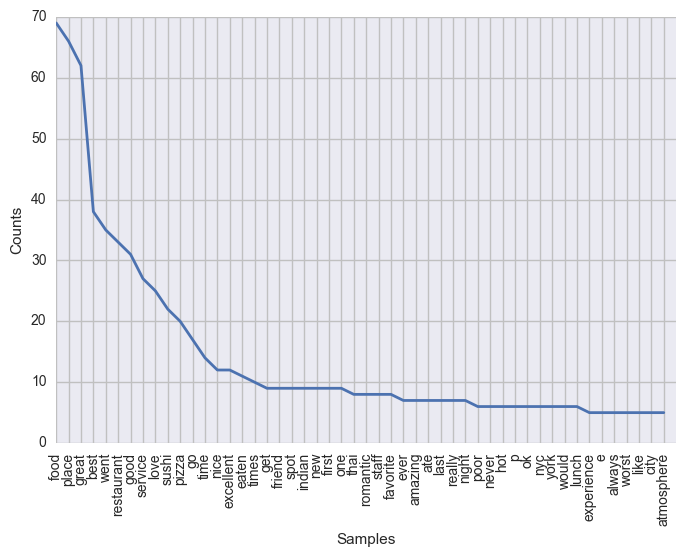

In [44]:
#Combine text (with stop words removed)
train_reviews_text = df_training.TEXT.to_string()
test_reviews_text = df_testing.TEXT.to_string()
semeval_reviews_text = clean_text_data(train_reviews_text,remove_stopwords=True) + clean_text_data(test_reviews_text,remove_stopwords=True)
#Compute Frequency Distribution
freq_dist = FreqDist(semeval_reviews_text.split(" "))
freq_dist.plot(50, cumulative=False)

Check the distribution of words in the Yelp restaurant reviews dataset.

In [42]:
#Read the Yelp review dataset from the pickle file
df_yelp_restaurant_reviews = pd.read_pickle('data/restaurant_reviews.pkl')
yelp_restaurant_reviews_text = df_yelp_restaurant_reviews.text.to_string()
yelp_restaurant_cleaned_text = clean_text_data(yelp_restaurant_reviews_text, remove_stopwords=True)


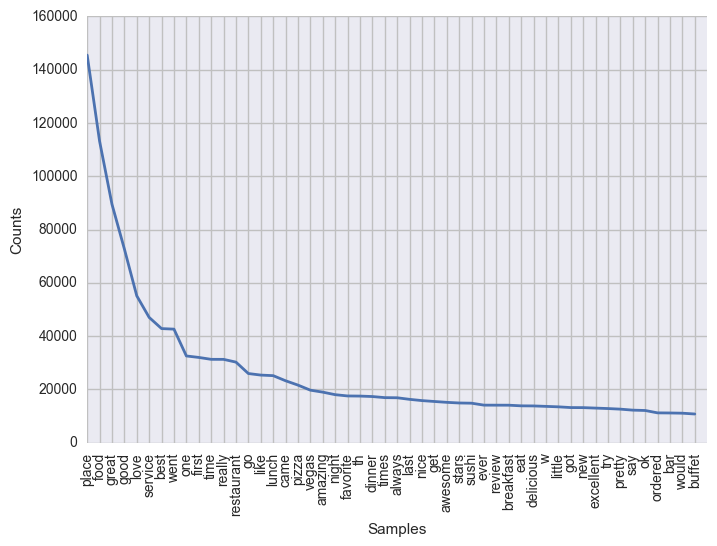

In [43]:
yelp_freq_dist = FreqDist(yelp_restaurant_cleaned_text.split(" "))
yelp_freq_dist.plot(50, cumulative=False)




** The frequency distributions of Semantic Evaluation and Yelp give us some very interesting insights. **

1) It appears that users mention the word **food** more than than **service** in the review.

2) It also seems that mostly if people like a restaurant, they use the word **great** more than any other word to describe a positive sentiment.

3) In terms of mentioning food by name, **pizza** and **sushi** top the list.

The next thing to do is to have a look at how the positive and negative sentiment classes are distributed amongst aspects. We know that a positive sentiment in our training dataset is -1 and positive sentiment is +1. A zero indicates a missing aspect for data prepared for the Multioutput Multiclass classification.

In [45]:
#Prepare training and testing datasets multilabel multioutput
X_train = df_training['TEXT']
y_train = df_training.drop('TEXT',axis=1)
X_test = df_testing['TEXT']
y_test = df_testing.drop('TEXT',axis=1)

#Prepare training and testing datasets multilabel only
X_train_multilabel = df_training_multilabel['TEXT']
y_train_multliabel = df_training_multilabel.drop('TEXT',axis=1)
X_test_multilabel = df_testing_multilabel['TEXT']
y_test_multilabel = df_testing_multilabel.drop('TEXT',axis=1)


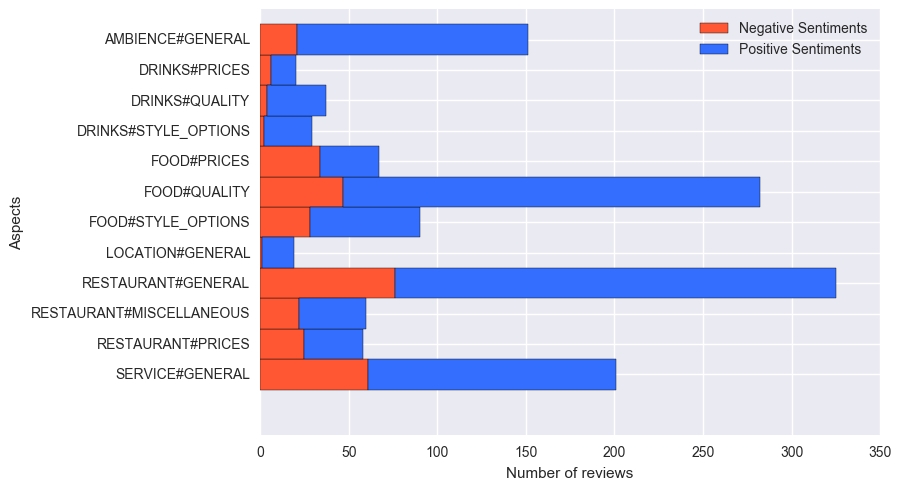

In [124]:
#Count +1 and -1 for all aspects
positives = []
negatives = []
col_names=[]
width = 1
for column in y_train:
    positives.append(y_train[column].value_counts()[1])
    negatives.append(y_train[column].value_counts()[-1])
    col_names.append(column)
N=np.arange(12)   
fig = plt.figure()
ax = plt.subplot(111)
neg=ax.barh(N, negatives, width, color='#FF5733', align='center' )
pos=ax.barh(N, positives, width, color='#336EFF',left=negatives,align='center')
ax.set_yticks(N)
ax.set_yticklabels(col_names,);
ax.legend((neg[0],pos[0]),('Negative Sentiments','Positive Sentiments'));
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Aspects')

The plot shows that most reviews have a sentiment assigned to **RESTAURANT#GENERAL** and **FOOD#QUALITY** aspects and only a handful of reviews have discussed location of the restaurant. What is even more interesting is that only a very small fraction of reviews have negative sentiment for location of the restaurant. The four main aspects are **RESTAURANT#GENERAL**, **FOOD#QUALITY**, **AMBIENCE#GENERAL** and **SERVICE#GENERAL**.

In [107]:
#Function to do Feature Scaling
def standardize_features(X_train,X_test, standardize=True):
    """
    Returns standardized features
    :param X_train: Training data to be standardized
    :param X_test : Testing data to be standardized
    :param standardize : A flag to indicate if we need data standardized
    :return: X_train_std,X_test_std: Standardized training and testing data
    """
    standardizer = StandardScaler()
    X_train_std = X_train
    X_test_std = X_test

    if(standardize):
        X_train_std = standardizer.fit_transform(X_train)
        X_test_std = standardizer.transform(X_test)

    return X_train_std,X_test_std, standardizer

### 2) Evaluation metrics for Multilabel Multiclass Classifiers ###

In order to measure the performance of a multilabel multiclass classifier we can use F1 score. F1 score is the weighted average of precision and recall. For multilabel multioutput case the F1(microaveraged) and F1(macroaveraged) can be given by the following equations.


<img src='images/f1_score_multiple.png'></img>

**Reference:** <a href="http://machinelearning.wustl.edu/mlpapers/paper_files/icml2004_GaoWLC04.pdf" target=_blank> A MFoM Learning Approach to Robust Multiclass Multi-Label Text Categorization</a>

As scikit-learn does not provide a built-in metrics we have to write a custom function to implement the above. The R is recall and P denotes precision for a class i in N labels.

In [109]:
#Function to compute F1_Score (microaveraged)
def compute_f1_score_micro(y_true, y_predicted):
    '''
    Description : Computes and returns F1 score microaveraged
    Arguments:
                 y_true:       True value
                 y_ predicted: Predicted values 
    '''
    TP,FP,TN,FN=0,0,0,0
    TP_sum,FP_sum,TN_sum,FN_sum=0,0,0,0
    for column_index in range(y_true.shape[1]):
        true_values = np.array(y_true)[:,column_index]
        predicted_values = np.array(y_predicted)[:,column_index]
        for index in range(len(true_values)):
            if(true_values[index]==predicted_values[index]==1):
                TP += 1
            elif(true_values[index]==predicted_values[index]==-1):
                TP += 1
            elif(true_values[index]==0 and predicted_values[index]!=0):
                FP += 1
            elif(true_values[index]!=0 and predicted_values[index]==0):
                FN += 1
            else:
                TN += 1   
        TP_sum = TP_sum + TP
        FP_sum = FP_sum + FP
        TN_sum = TN_sum + TN
        FN_sum = FN_sum + FN
    return ((2*TP_sum)/(FP_sum+FN_sum+(2*TP_sum)))

We also need to evaluate the sentiment polarity of the aspects. In order to evaluate the polarity we are using the same strategy as given in
<a href="http://galanisd.github.io/Papers/2015SemEval_ABSA_overview.pdf" target="_blank"> SemEval-2015 Task 12: Aspect Based Sentiment Analysis </a>.
<br/> Which defines the _polarity accuracy as the number of correctly predicted polarity labels of aspect categories, divided by the total number of aspect categories.**Note that we are not using neutral sentiment. The score is only for positive or negative sentiments**_

In [110]:
#Function to compute accuracy of polarity prediction
def compute_polarity_accuracy_score(y_true, y_predicted):
    '''
    Description : Compute the accuracy of the polarity
    Arguments : 
                   y_true :   True value
                   y_ predicted: Predicted values 
    '''
    correct = 0
    total = 0
    for column_index in range(y_true.shape[1]):
        true_values = np.array(y_true)[:,column_index]
        predicted_values = np.array(y_predicted)[:,column_index]
        for index in range(len(true_values)):
            if(true_values[index]==predicted_values[index]==1):
                correct += 1
                total += 1
            elif(true_values[index]==predicted_values[index]==-1):
                correct += 1
                total += 1
            elif(true_values[index]==1 and predicted_values[index]==-1):
                total += 1
            elif(true_values[index]==-1 and predicted_values[index]==1):
                total += 1
            else:
                pass
    return (correct/total)
    

** A generic utility function to find labels and polarity given a text **

In [220]:
#Function to decode and print output labels and polarity for a review
def output_to_labels(output):
    '''
     Description: Converts predicted output for a review into labels and polarity
     Arguments: output a numpy array
                
    '''
    labels = ['SERVICE#GENERAL', 'RESTAURANT#PRICES',
       'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#GENERAL', 'LOCATION#GENERAL',
       'FOOD#STYLE_OPTIONS', 'FOOD#QUALITY', 'FOOD#PRICES',
       'DRINKS#STYLE_OPTIONS', 'DRINKS#QUALITY', 'DRINKS#PRICES',
       'AMBIENCE#GENERAL']
    for index in range(len(labels)-1):
        value = output[0,index]
        if(value == 1):
            print(labels[index],':',' ','positive')
        elif(value == -1):
            print(labels[index],':',' ','negative')
    

In [112]:
#Function to decode and print output labels and polarity for a review
def output_to_labels_multilabel(output):
    '''
     Description: Converts predicted output for a review into labels and polarity
     Arguments: output a numpy array
                
    '''
    labels = y_train_multliabel.columns.tolist()
    for index in np.arange(len(labels)-1):
        value = output[index]
        if(value == 1):
            print(labels[index])

In [180]:
#Function to find aspects and sentiment polarity given a review
def analyze_review(classifier, review_text,multilabel=False,standardizer=False):
    '''
    Description : Detects Aspects and finds the polarities given review text
    Arguments : 
                review_text : A string with review sentence/sentences
                classifier: A model used to predict the aspects and polarities
    '''
    dictionary = {'review':clean_text_data(review_text)}
    df_input=pd.DataFrame(dictionary,index=np.arange(len(dictionary.keys())))
    X = df_input['review']
    if(standardizer):
        X = standardizer.transform(X)
    output = classifier.predict(X)
    if(multilabel):
        output_to_labels_multilabel(output[0])
    else:
        output_to_labels(output)
    

In [114]:
#Make scoring function
f1_scorer = make_scorer(compute_f1_score_micro, greater_is_better=True)

### 3) Baseline Classifer (RandomForest with CountVectorizer) 

**Multioutput Multiclass**

In [212]:
#RandomForest Classifier
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('clf', MultiOutputClassifier(RandomForestClassifier(max_depth=3,class_weight='balanced')))])
#RandomForest specific parameters
parameters = {
'clf__estimator__n_estimators': [100,300,350]
}
#Find the optimal parameters for RandomForest
model_parameter_selection = GridSearchCV(pipeline,param_grid=parameters,cv=5,scoring = f1_scorer)
model_parameter_selection.fit(X_train, y_train)
print("Best Estimator Parameters are:",model_parameter_selection.best_params_, model_parameter_selection.best_score_)
y_predicted = model_parameter_selection.predict(X_test)
f1_micro=compute_f1_score_micro(y_test,y_predicted)
polarity_accuracy = compute_polarity_accuracy_score(y_test,y_predicted)
print('F1-Score:',f1_micro)
print('Polarity Accuracy:',polarity_accuracy)

Best Estimator Parameters are: {'clf__estimator__n_estimators': 350} 0.726086723944
F1-Score: 0.727958510136728
Polarity Accuracy: 0.8407079646017699


**Multilabel only**

In [213]:
#RandomForest Classifier
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(max_depth=3,class_weight='balanced')))])
#RandomForest specific parameters
parameters = {
'clf__estimator__n_estimators': [100,300,350]
}
#Find the optimal parameters for RandomForest
model_parameter_selection = GridSearchCV(pipeline,param_grid=parameters,cv=5,scoring = 'f1_micro')
model_parameter_selection.fit(X_train_multilabel, y_train_multliabel)
print("Best Estimator Parameters are:",model_parameter_selection.best_params_, model_parameter_selection.best_score_)
y_predicted = model_parameter_selection.predict(X_test_multilabel)
f1_score = metrics.f1_score(y_test_multilabel,y_predicted,average='micro')
print('F1-Score:',f1_score)

Best Estimator Parameters are: {'clf__estimator__n_estimators': 350} 0.569367103467
F1-Score: 0.609427609428


### 4) Word Embeddings

Word Embeddings are dense low dimensional representation of words. Word Embeddings convert words from a vocabulary into vectors of real numbers. Word Embeddings have been used in many Sentiment Analysis tasks and have been found to be quite effective. An example model is given in <a href="http://www.cs.ubc.ca/~rjoty/paper/emnlp-paper-drnn-cr.pdf" target=_blank>Fine-grained Opinion Mining with Recurrent Neural Networks and Word Embeddings</a>. Word Embeddings or Vector Space Models (VSM) place words with semantic similarity nearby in the vector space.  

Although we can use Word Embeddings created from generic corpuses. It is a good idea to generate a domain specific Word Embeddings model as shown in <a href="http://nlp.stanford.edu/pubs/hamilton2016inducing.pdf">Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora</a> 

Yelp has made public a huge dataset as part of its data challenge program. We used the scripts available at <a href="https://github.com/titipata/yelp_dataset_challenge" target=_blank>Yelp dataset challenge scripts</a> to create Word Embeddings. The scripts do not work with the latest version of Tensorflow (r0.12) and Python 3 so we had to modify them slightly. The updated scripts are available at <a href="https://github.com/umairacheema/yelp_dataset_challenge/tree/hotfix/python3x"target=_blank>Yelp Util for Tensorflow r0.12</a>

The jupyter notebook to build domain specific word embedding for Restaurants is given in the aforementioned github repository as well. There are **21,892** restaurants and **9,90,627** reviews in the corpus used to build domain specific WordEmbeddings.

In [201]:
#The following code will not run in notebook as it requires the yelword2vec
#created using code in 
#https://github.com/umairacheema/yelp_dataset_challenge/blob/hotfix/python3x/examples/domain_specific_word_embeddings.ipynb
#yelpword2vec is 77M in size and cannot be uploaded to github
from gensim.models.word2vec import Word2Vec
w2vmodel = Word2Vec.load_word2vec_format('data/yelpword2vec', binary=False)


In [202]:
#Function to compute vectorized representation of a single review
#Review should be a list of words
def vectorize_review_w2v(w2vmodel,review,size=100):
    '''
    Description : Given word2vec model and review compute average
                  feature vector
    Arguments :
                 w2vmodel : Trained word2vec model
                 review : A single review as a list of words
    '''
    #Clean the review data
    review = clean_text_data(review)
    #Convert review into a list of words.
    text = review.split()
    word_count = 0
    vector = np.zeros(size).reshape((1, size))
    w2vmodel_words = set(w2vmodel.index2word)
    for word in text:
        if word in w2vmodel_words:
            #vector += w2vmodel[word].reshape((1,size))
            vector = np.add(vector,w2vmodel[word])
            word_count += 1
    if word_count>0:
        vector = vector/word_count
    return vector
   

In [203]:
#Function to vectorize multiple reviews using word2vec
def vectorize_reviews_w2v(w2vmodel,reviews,size=100):
    '''
    Description: Given a Pandas Series with reviews, compute dense
                 vectorized representation using Word2Vec
    Arguments :
                w2vmodel : Trained word2vec model
                reviews: A Pandas series with all the reviews.
    '''
    #default value of 100 used by yelp_util
    #Initialize a numpy array to store  feature vector for
    #all reviews
    vectorized_features = np.zeros((len(reviews),size),dtype='float32')
    #Initialize a vector index
    index = 0
    for review in reviews:
        vectorized_features[index] = vectorize_review_w2v(w2vmodel,review,size)
        index += 1
    return vectorized_features

In [204]:
#Convert training and testing features 
# into feature vectors
training_features = vectorize_reviews_w2v(w2vmodel,X_train,size=100)
testing_features = vectorize_reviews_w2v(w2vmodel,X_test)

**As RandomForest does not require Standardized features we are not doing feature scaling or standardization**

### 5) Random Forest with Word2Vec

In [216]:
def random_forest(training_features, testing_features):
    rfclf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced'))
    #RandomForest specific parameters
    parameters = {
    'estimator__n_estimators': [100,300,350],
    'estimator__max_depth':[3,4,5]
    }
    #Find the optimal parameters for RandomForest
    rf_parameter_selection = GridSearchCV(rfclf,param_grid=parameters,cv=5,scoring = f1_scorer)
    rf_parameter_selection.fit(training_features, y_train)
    print("Best Estimator Parameters are:",rf_parameter_selection.best_params_, rf_parameter_selection.best_score_)
    rf_y_predicted = rf_parameter_selection.predict(testing_features)
    rf_f1_micro=compute_f1_score_micro(y_test,rf_y_predicted)
    rf_polarity_accuracy = compute_polarity_accuracy_score(y_test,rf_y_predicted)
    print('F1-Score:',f1_micro)
    print('Polarity Accuracy:',polarity_accuracy)
    return rf_parameter_selection

In [218]:
rf=random_forest(training_features,testing_features)

Best Estimator Parameters are: {'estimator__max_depth': 5, 'estimator__n_estimators': 350} 0.71215408451
F1-Score: 0.727958510136728
Polarity Accuracy: 0.8407079646017699


In [283]:
#Function to test on an unseen short review
def classify_short_review(classifier,w2vmodel,size=100,standardizer=False,review=None):
    review_text = "I love the food. The service was terrible. I hated the ambience."
    if(review):
        review_text = review
    cleaned = clean_text_data(review_text)
    X=vectorize_review_w2v(w2vmodel,cleaned,size)
    if(standardizer):
        X=standardizer.transform(X)
    predicted = classifier.predict(X)
    print(output_to_labels(predicted))

In [235]:
classify_short_review(rf,w2vmodel)

SERVICE#GENERAL :   positive
RESTAURANT#GENERAL :   positive
FOOD#QUALITY :   positive
None


### 6) Support Vector Machines with Word2Vec

In [223]:
from sklearn.svm import SVC
def SVM(training_features, testing_features):
    svmclf = MultiOutputClassifier(SVC(kernel='rbf'))
    #Support Vector Machine specific parameters
    parameters = {
    'estimator__gamma': [0.0001,0.001,0.01,0.1],
    'estimator__C':[0.1,1,10,100]
    }
    #As an additional step we need to standardize the features
    training_features_std, testing_features_std, standardizer = standardize_features(training_features,testing_features) 
    #Find the optimal parameters for Support Vector Machine Classifier
    svm_parameter_selection = GridSearchCV(svmclf,param_grid=parameters,cv=5,scoring = f1_scorer)
    svm_parameter_selection.fit(training_features_std, y_train)
    print("Best Estimator Parameters are:",svm_parameter_selection.best_params_, svm_parameter_selection.best_score_)
    svm_y_predicted = svm_parameter_selection.predict(testing_features_std)
    svm_f1_micro=compute_f1_score_micro(y_test,svm_y_predicted)
    svm_polarity_accuracy = compute_polarity_accuracy_score(y_test,svm_y_predicted)
    print('SVM F1 Score:',svm_f1_micro)
    print('SVM Polarity Accuracy:',svm_polarity_accuracy)
    return svm_parameter_selection, standardizer

In [236]:
svm, standardizer=SVM(training_features,testing_features)

Best Estimator Parameters are: {'estimator__gamma': 0.001, 'estimator__C': 10} 0.733305052885
SVM F1 Score: 0.7398895027624309
SVM Polarity Accuracy: 0.9130434782608695


In [233]:
classify_short_review(svm,w2vmodel,size=100,standardizer=standardizer)

SERVICE#GENERAL :   positive
RESTAURANT#GENERAL :   negative
FOOD#QUALITY :   positive
None


**It is important to note that even with fine tuned Support Vector Machines the test accuracy is not very high. This could mean that we need to improve our WordEmbeddings model. Previously we used a feature size of 300 as that was hardcoded in the yelp util. We also did not add the SemEval datasets while training the word2vec model. We now need to train a new Word2Vector model and train it on the corpus. We shall also try Continuous Bag of Words (CBOW) as well as Skip-n gram based models.**

### 7) Support Vector Machines with Bigger Feature Size and CBOW

In [238]:
#The following code will not run in notebook as it requires the restaurant_reviews.pkl
#created using code in
#https://github.com/umairacheema/yelp_dataset_challenge/blob/hotfix/python3x/examples/domain_specific_word_embeddings.ipynb
#restaurant_reviews.pkl is 740M in size and cannot be uploaded to github
df_yelp_restaurant_reviews = pd.read_pickle('data/restaurant_reviews.pkl')

In [239]:
#Combine the review data with the Semantic Evaluation data
yelp_reviews_text = df_yelp_restaurant_reviews.text
combined_reviews_text = pd.concat([yelp_reviews_text,X_train],axis=0)
yelp_reviews_text = yelp_reviews_text.to_string(header=False,index=False)
yelp_reviews_text = clean_text_data(yelp_reviews_text)
#Save all reviews in a text file
file = open('data/yelp_semeval_reviews.txt', 'w')
file.write(yelp_reviews_text)
file.close()

In [240]:
import multiprocessing
from gensim.models.word2vec import LineSentence
#Convert it into a format that word2vec can understand
linesentences = LineSentence('data/yelp_semeval_reviews.txt')
#Build the model with higher number of features
n_dims = 500
cbow_model = Word2Vec(linesentences,size=n_dims,workers=multiprocessing.cpu_count())


In [241]:
#Convert training and testing features 
# into feature vectors
training_features_cbow = vectorize_reviews_w2v(cbow_model,X_train,size=n_dims)
testing_features_cbow = vectorize_reviews_w2v(cbow_model,X_test,size=n_dims)


In [242]:
svm_cbow, standardizer=SVM(training_features_cbow,testing_features_cbow)

Best Estimator Parameters are: {'estimator__gamma': 0.0001, 'estimator__C': 10} 0.720127350354
SVM F1 Score: 0.7338709677419355
SVM Polarity Accuracy: 0.9066666666666666


### 8) Support Vector Machines with Skip gram

In [243]:
#Build a Skip gram model
n_dims = 400
sg_model = Word2Vec(linesentences,size=n_dims,workers=multiprocessing.cpu_count(),sg=1)

In [245]:
training_features_sg = vectorize_reviews_w2v(sg_model,X_train,size=n_dims)
testing_features_sg = vectorize_reviews_w2v(sg_model,X_test,size=n_dims)

In [246]:
svm_sg, standardizer = SVM(training_features_sg,testing_features_sg)

Best Estimator Parameters are: {'estimator__gamma': 0.001, 'estimator__C': 10} 0.720292128109
SVM F1 Score: 0.7517642175176422
SVM Polarity Accuracy: 0.9066147859922179


### 9) Support Vector Machines with gensim Phrase model  

In [250]:
from gensim.models import Phrases
from nltk.corpus import stopwords

In [251]:
#Create list of list of words.
sentences = []
for (index, row) in df_yelp_restaurant_reviews.iterrows():
    text = df_yelp_restaurant_reviews.text[index]
    cleaned = clean_text_data(text)
    words = cleaned.split(" ")
    sentences.append(words)

In [255]:
#This is a time consuming process
#Takes approximately an hour on 2.2 GHz Intel Core i7 with 16G RAM
import time
start = time.time()
bigram_transformer = Phrases(sentences)
bigram_model = Word2Vec(bigram_transformer[sentences], size=500,workers=multiprocessing.cpu_count())
time_elapsed =time.time()-start
print('Time taken:',time_elapsed)

Time taken: 3310.154627084732


In [262]:
#Save the model as it is time consuming to build one
bigram_model.save_word2vec_format('data/yelphraseword2vec',binary=True)

In [264]:
bg_model = Word2Vec.load_word2vec_format('data/yelphraseword2vec', binary=True)
bg_model.most_similar('sushi')

[('nigiri', 0.628957211971283),
 ('sashimi', 0.6185207366943359),
 ('ayce_sushi', 0.6114140748977661),
 ('raw_fish', 0.5325007438659668),
 ('california_rolls', 0.5213685035705566),
 ('dim_sum', 0.5194767713546753),
 ('ayce', 0.5128969550132751),
 ('rainbow_roll', 0.5115077495574951),
 ('ramen', 0.4964790940284729),
 ('maki_rolls', 0.48887306451797485)]

In [265]:
n_dims=500
training_features_bg = vectorize_reviews_w2v(bg_model,X_train,size=n_dims)
testing_features_bg = vectorize_reviews_w2v(bg_model,X_test,size=n_dims)

In [266]:
svm_bg, standardizer = SVM(training_features_bg,testing_features_bg)

Best Estimator Parameters are: {'estimator__gamma': 0.001, 'estimator__C': 10} 0.741167340589
SVM F1 Score: 0.7648610265773991
SVM Polarity Accuracy: 0.9132075471698113


### 10) SVM using Doc2Vec 

In [299]:
#Use combined Yelp and SemEval Training datasets
combined_sentences = []
for review in combined_reviews_text:
    review = clean_text_data(review)
    words = review.split(" ")
    combined_sentences.append(words)


In [317]:
#Train and Testing sentences
train_sentences=[]
for review in X_train:
    review = clean_text_data(review)
    words = review.split(" ")
    train_sentences.append(words)

test_sentences = []  
for review in X_test:
    review = clean_text_data(review)
    words = review.split(" ")
    test_sentences.append(words)
#Yelp sentences
unsupervised = []
for (index, row) in df_yelp_restaurant_reviews.iterrows():
    text = df_yelp_restaurant_reviews.text[index]
    cleaned = clean_text_data(text)
    words = cleaned.split(" ")
    unsupervised.append(words)

In [330]:
#We are treating each review as a single sentence.
# so we need to create LabeledSentences(required by GenSim)
# Following resource was found quite useful for preparing Doc2Vec model
#https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis

from gensim.models.doc2vec import LabeledSentence
train_labeled_sentences = []
for index in np.arange(len(train_sentences)):
    train_labeled_sentences.append(LabeledSentence(train_sentences[index],'train_'+str(index)))

test_labeled_sentences = []
for index in np.arange(len(test_sentences)):
    test_labeled_sentences.append(LabeledSentence(test_sentences[index],'test_'+str(index)))

yelp_labeled_sentences = []
for index in np.arange(len(unsupervised)):
    yelp_labeled_sentences.append(LabeledSentence(unsupervised[index],'yelp_'+str(index)))


In [473]:
#Train the model
from gensim.models.doc2vec import Doc2Vec
from random import shuffle
start = time.time()
epochs = 10
size = 100
#Combined all tagged documents for building vocabulary
tagged_docs = train_labeled_sentences+test_labeled_sentences+yelp_labeled_sentences
doc2vmodel = Doc2Vec(tagged_docs,workers=multiprocessing.cpu_count(),size=size,window=8,min_count=2)
time_elapsed =time.time()-start
print('Time taken:',time_elapsed)

Time taken: 1412.3533449172974


In [482]:
#Train the model using training data
start = time.time()
all_training_docs = train_labeled_sentences+yelp_labeled_sentences[1:40000]
for epoch in range(epochs):
    shuffle(all_training_docs)
    doc2vmodel.train(all_training_docs)
time_elapsed =time.time()-start
print('Time taken:',time_elapsed)

Time taken: 322.45857310295105


In [483]:
#Save the model

#doc2vmodel.save('data/doc2vmodel')

In [484]:
#Get training and testing features
size=100
training_features_d2v=np.zeros(shape=(len(train_sentences),size))
for i,sentence in enumerate(train_sentences):
    training_features_d2v[i] = doc2vmodel.infer_vector(sentence)
    
testing_features_d2v=np.zeros(shape=(len(test_sentences),size))

for i,sentence in enumerate(test_sentences):
    testing_features_d2v[i] = doc2vmodel.infer_vector(sentence)
    

In [485]:
svm_d2v, standardizer = SVM(training_features_d2v,testing_features_d2v)

Best Estimator Parameters are: {'estimator__gamma': 0.001, 'estimator__C': 10} 0.684246868971
SVM F1 Score: 0.7112723973690179
SVM Polarity Accuracy: 0.8438818565400844


In [486]:
#Test it on X_test[88]
print(y_test.iloc[88])

SERVICE#GENERAL            -1.0
RESTAURANT#PRICES          -1.0
RESTAURANT#MISCELLANEOUS    0.0
RESTAURANT#GENERAL         -1.0
LOCATION#GENERAL            0.0
FOOD#STYLE_OPTIONS          0.0
FOOD#QUALITY               -1.0
FOOD#PRICES                -1.0
DRINKS#STYLE_OPTIONS       -1.0
DRINKS#QUALITY              0.0
DRINKS#PRICES              -1.0
AMBIENCE#GENERAL            1.0
Name: 88, dtype: float64


In [487]:

review = X_test[88]
review=clean_text_data(review)
sentence = review.split(" ")
vector = doc2vmodel.infer_vector(sentence)
vector = vector.reshape(1,100)
vector = standardizer.transform(vector)

In [488]:
predicted = svm_d2v.predict(vector)
print(predicted)

[[-1.  0.  0. -1.  0. -1.  0. -1.  0.  0.  0.  0.]]


In [489]:
classify_short_review(svm_d2v,doc2vmodel,size=100,standardizer=standardizer)

SERVICE#GENERAL :   positive
RESTAURANT#GENERAL :   positive
FOOD#QUALITY :   positive
None


**References:**

  [1] Liu, B, 2015. Sentiment Analysis. 1st ed. United States of America: Cambridge University   Press.
  
  [1] Liu, B, 2015. Sentiment Analysis. 1st ed. United States of America: Cambridge University   Press.


